In [1]:
# 社群媒體資料分析實務 第一次作業 M10515038 唐毅

In [2]:
import elasticsearch
import pyes
import json

import pandas as pd
import numpy as np

%matplotlib inline

#months = ['Jan.', 'Feb.', 'Mar.', 'Apr.', 'May.', 'Jun.', 'Jul.', 'Aug.', 'Sep.', 'Oct.', 'Nov.', 'Dec.']
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

keywordsSetOne = ['cve', 'vulnerability', 'exploit']
keywordsSetTwo = ['ransomware', 'hacktivism', 'cyber espionage']

conn = pyes.es.ES('127.0.0.1:9200')

In [3]:
# 2. a) 共計有多少Twitter參與這類關鍵字議題討論？

boolQuery = pyes.query.BoolQuery()

#termQuery = pyes.query.TermQuery(field = 'text', value = 'cve')

termFilter = pyes.filters.TermsFilter(field = 'text', values = keywordsSetTwo)

esrange = pyes.ESRange(field = 'created_at',
                       from_value = 'Wed Jan 01 00:00:00 +0000 2014',
                       to_value = 'Wed Dec 31 23:59:59 +0000 2014', 
                       include_lower = True,
                       include_upper = False)
rangeQuery = pyes.query.RangeQuery(qrange = esrange)

boolQuery.add_must(termFilter)
boolQuery.add_must(rangeQuery)

termAgg = pyes.aggs.TermsAgg('uid', field = 'uid')

querySearch = pyes.query.Search(boolQuery)
querySearch.agg.add(termAgg)

result = conn.search(query = querySearch, indices = 'twitter2', type = 'tweet')

#print(json.dumps(result.aggs, indent = 2))

uidIdxList = []

for uid in result.aggs['uid']['buckets']:
        uidIdxList.append(uid['key'])
        
print (len(uidIdxList))

40


In [4]:
# 2. b) 共計有多少Tweets?
boolQuery = pyes.query.BoolQuery()

termFilter = pyes.filters.TermsFilter(field = 'text', values = keywordsSetTwo)

esrange = pyes.ESRange(field = 'created_at',
                       from_value = 'Wed Jan 01 00:00:00 +0000 2014',
                       to_value = 'Wed Dec 31 23:59:59 +0000 2014', 
                       include_lower = True,
                       include_upper = False)
rangeQuery = pyes.query.RangeQuery(qrange = esrange)

boolQuery.add_must(termFilter)
boolQuery.add_must(rangeQuery)

result = conn.search(query = boolQuery, indices = 'twitter2', type = 'tweet')

print(len(result))

220


In [5]:
# 2. c) 每個月參與的Twitter數量長條圖。

boolQuery = pyes.query.BoolQuery()

termFilter = pyes.filters.TermsFilter(field = 'text', values = keywordsSetTwo)

esrange = pyes.ESRange(field = 'created_at',
                       from_value = 'Wed Jan 01 00:00:00 +0000 2014',
                       to_value = 'Wed Dec 31 23:59:59 +0000 2014', 
                       include_lower = True,
                       include_upper = False)
rangeQuery = pyes.query.RangeQuery(qrange = esrange)

boolQuery.add_must(termFilter)
boolQuery.add_must(rangeQuery)


termAgg = pyes.aggs.DateHistogramAgg('month',
                                  field = 'created_at',
                                  interval = 'month',
                                  sub_aggs = [])

termAggInner = pyes.aggs.TermsAgg('uid', field = 'uid')

termAgg.sub_aggs.append(termAggInner)

querySearch = pyes.query.Search(boolQuery)
querySearch.agg.add(termAgg)

result = conn.search(query = querySearch, indices = 'twitter2', type = 'tweet')

#print(json.dumps(result.aggs, indent = 2))

numOfTweetForEachUserInEachMonth = []

idxOfMonth = 0
for month in result.aggs['month']['buckets']:
        numOfTweetForEachUserInEachMonth.append([])
        for uid in month['uid']['buckets']:
            numOfTweetForEachUserInEachMonth[idxOfMonth].append(uid['doc_count'])
        idxOfMonth += 1

numOfTwitterInEachMonth = []

for i in range(0, len(numOfTweetForEachUserInEachMonth)):
    #print(numOfTweetForEachUserInEachMonth[i])
    numOfTwitterInEachMonth.append(len(numOfTweetForEachUserInEachMonth[i]))
    
print(numOfTwitterInEachMonth)

from bokeh.charts import Bar, output_file, show, hplot

# best support is with data in a format that is table-like

data = {
    'months': months,
    'numOfTwitterInEachMonth': numOfTwitterInEachMonth
}

# x-axis labels pulled from the interpreter column, stacking labels from sample column
numOfTwitterInEachMonthBar = Bar(data,
                                 values='numOfTwitterInEachMonth',
                                 label='months',
                                 title="numOfTwitterInEachMonth",
                                 plot_width=400)

output_file("numOfTwitterInEachMonthBar.html")
show(numOfTwitterInEachMonthBar)

[6, 6, 4, 4, 15, 21, 12, 10, 10, 6, 10, 16]


In [6]:
# 2. d) 每個月參Tweets數量長條圖。

boolQuery = pyes.query.BoolQuery()

termFilter = pyes.filters.TermsFilter(field = 'text', values = keywordsSetTwo)

esrange = pyes.ESRange(field = 'created_at',
                       from_value = 'Wed Jan 01 00:00:00 +0000 2014',
                       to_value = 'Wed Dec 31 23:59:59 +0000 2014', 
                       include_lower = True,
                       include_upper = False)
rangeQuery = pyes.query.RangeQuery(qrange = esrange)

boolQuery.add_must(termFilter)
boolQuery.add_must(rangeQuery)


termAgg = pyes.aggs.DateHistogramAgg('month',
                                  field = 'created_at',
                                  interval = 'month',
                                  sub_aggs = [])

querySearch = pyes.query.Search(boolQuery)
querySearch.agg.add(termAgg)

result = conn.search(query = querySearch, indices = 'twitter2', type = 'tweet')

#print(json.dumps(result.aggs, indent = 2))

numOfTweetInEachMonth = []

for month in result.aggs['month']['buckets']:
        numOfTweetInEachMonth.append(month['doc_count'])

print(numOfTweetInEachMonth)

data = {
    'months': months,
    'numOfTweetInEachMonth': numOfTweetInEachMonth
}

# x-axis labels pulled from the interpreter column, stacking labels from sample column
numOfTweetInEachMonthBar = Bar(data,
                                 values='numOfTweetInEachMonth',
                                 label='months',
                                 title="numOfTweetInEachMonth",
                                 plot_width=400)

output_file("numOfTweetInEachMonthBar.html")
show(numOfTweetInEachMonthBar)

INFO:bokeh.core.state:Session output file 'numOfTweetInEachMonthBar.html' already exists, will be overwritten.


[7, 7, 5, 6, 29, 48, 22, 19, 16, 17, 19, 25]


209
11


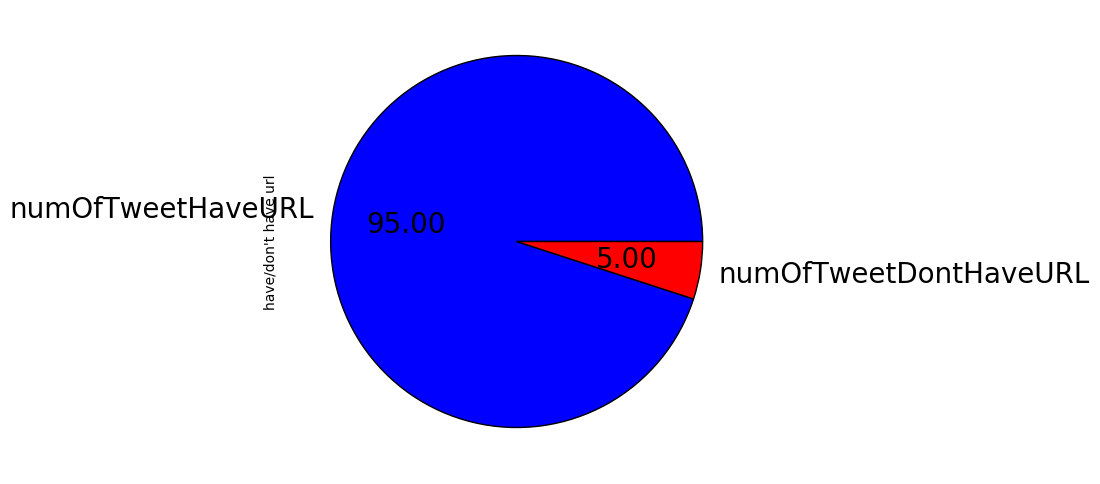

In [7]:
# 2. e)其中有URL與無URL的Tweets的比例圓餅圖。

numOfTweetHaveURL = 0
numOfTweetDontHaveURL = 0
for i in range(0, len(result)):
    if result[i]['entities']['urls'] != []:
        numOfTweetHaveURL += 1

numOfTweetDontHaveURL = len(result) - numOfTweetHaveURL

print(numOfTweetHaveURL)
print(numOfTweetDontHaveURL)

plotData = [numOfTweetHaveURL, numOfTweetDontHaveURL]
plotIdx = ['numOfTweetHaveURL', 'numOfTweetDontHaveURL']

series = pd.Series(plotData, plotIdx, name = "have/don't have url")
series.plot.pie(colors=['b', 'r'], autopct='%.2f', fontsize=20, figsize=(6, 6))

In [8]:
# 2. f) 請依照每個月繪製各Twitter所提到CVE的箱型圖。


boolQuery = pyes.query.BoolQuery()

termQuery = pyes.query.TermQuery(field = 'text', value = 'cve')

esrange = pyes.ESRange(field = 'created_at',
                       from_value = 'Wed Jan 01 00:00:00 +0000 2014',
                       to_value = 'Wed Dec 31 23:59:59 +0000 2014', 
                       include_lower = True,
                       include_upper = False)
rangeQuery = pyes.query.RangeQuery(qrange = esrange)

boolQuery.add_must(termQuery)
boolQuery.add_must(rangeQuery)


termAgg = pyes.aggs.DateHistogramAgg('month',
                                  field = 'created_at',
                                  interval = 'month',
                                  sub_aggs = [])

termAggInner = pyes.aggs.TermsAgg('uid', field = 'uid')

termAgg.sub_aggs.append(termAggInner)

querySearch = pyes.query.Search(boolQuery)
querySearch.agg.add(termAgg)

result = conn.search(query = querySearch, indices = 'twitter2', type = 'tweet')

#print(json.dumps(result.aggs, indent = 2))

numOfTweetForEachUserInEachMonth = []

idxOfMonth = 0
for month in result.aggs['month']['buckets']:
        numOfTweetForEachUserInEachMonth.append([])
        for uid in month['uid']['buckets']:
            numOfTweetForEachUserInEachMonth[idxOfMonth].append(uid['doc_count'])
        idxOfMonth += 1

numOfTwitterInEachMonth = []

for i in range(0, len(numOfTweetForEachUserInEachMonth)):
    #print(numOfTweetForEachUserInEachMonth[i])
    numOfTwitterInEachMonth.append(len(numOfTweetForEachUserInEachMonth[i]))
    
print(numOfTwitterInEachMonth)


from bokeh.charts import BoxPlot, output_file, show

plotData = []
idxOfPlotData = 0

for i in range(0, len(numOfTweetForEachUserInEachMonth)):
    for j in range(0, len(numOfTweetForEachUserInEachMonth[i])):
        pData = {}
        pData['month'] = months[i]
        pData['times'] = numOfTweetForEachUserInEachMonth[i][j]
        
        plotData.append(pData)
        idxOfPlotData += 1

df = pd.DataFrame(plotData)

title = "numOfTweetForEachUserInEachMonth"
box_plot = BoxPlot(df,
                   label = 'month',
                   values = 'times',
                   color = 'month',
                   title = title)

output_file("numOfTweetForEachUserInEachMonth.html",
            title ="numOfTweetForEachUserInEachMonth.py example")

show(box_plot)

[3, 10, 10, 13, 10, 11, 6, 8, 28, 27, 10, 6]


INFO:bokeh.core.state:Session output file 'numOfTweetForEachUserInEachMonth.html' already exists, will be overwritten.
